<div style="
    background-color: #f7f7f7;
    background-image: url(''), url('') ;
    background-position: left bottom, right top;
    background-repeat: no-repeat,  no-repeat;
    background-size: auto 60px, auto 160px;
    border-radius: 5px;
    box-shadow: 0px 3px 1px -2px rgba(0, 0, 0, 0.2), 0px 2px 2px 0px rgba(0, 0, 0, 0.14), 0px 1px 5px 0px rgba(0,0,0,.12);">

<h1 style="
    color: #2a4cdf;
    font-style: normal;
    font-size: 2.25rem;
    line-height: 1.4em;
    font-weight: 600;
    padding: 30px 200px 0px 30px;"> 
       Case Study: Distribution Shift in Perovskite Property Prediction</h1>

<p style="
    line-height: 1.4em;
    padding: 30px 200px 0px 30px;">
    
This notebook demonstrates how compositional evolution in perovskite research creates distribution shift challenges for machine learning models. Models trained on historical data underperform when applied to modern compositions.  
</p>

<p style="font-size: 1.25em; font-style: italic; padding: 5px 200px 30px 30px;">
</p>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import warnings

warnings.filterwarnings('ignore')
import os

np.random.seed(42)

# Nature-inspired style
plt.rcParams.update(
    {
        'font.family': 'sans-serif',
        'font.size': 9,
        'axes.linewidth': 0.8,
        'axes.labelsize': 9,
        'axes.titlesize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
        'lines.linewidth': 1.2,
        'lines.markersize': 4,
        'axes.spines.top': True,
        'axes.spines.right': True,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'figure.dpi': 300,
    }
)

# Color scheme
colors = {
    'blue': '#1f77b4',
    'red': '#ff0e5a',
    'orange': '#ff9408',
    'green': '#4cd8a5',
}

## 1. Load and Prepare Data

In [2]:
# Load the database
df = pd.read_parquet(
    'perovskite_solar_cell_database.parquet',
    columns=[
        'data.ref.publication_date',
        'data.perovskite.band_gap',
        'data.jv.default_PCE',
        'data.perovskite.composition_a_ions',
        'data.perovskite.composition_b_ions',
        'data.perovskite.composition_c_ions',
        'data.perovskite.composition_a_ions_coefficients',
        'data.perovskite.composition_b_ions_coefficients',
        'data.perovskite.composition_c_ions_coefficients',
    ],
)

df.columns = [
    'pub_date',
    'band_gap',
    'PCE',
    'a_ions',
    'b_ions',
    'c_ions',
    'a_coef',
    'b_coef',
    'c_coef',
]
df['pub_year'] = pd.to_datetime(df['pub_date'], errors='coerce').dt.year
df['band_gap'] = pd.to_numeric(df['band_gap'], errors='coerce')
df['PCE'] = pd.to_numeric(df['PCE'], errors='coerce')

print(f'Loaded {len(df):,} records')
print(f'  With bandgap: {df["band_gap"].notna().sum():,}')
print(f'  With PCE: {df["PCE"].notna().sum():,}')

Loaded 48,380 records
  With bandgap: 37,490
  With PCE: 47,399


## 2. Feature Engineering

In [3]:
def get_features(row):
    """Extract normalized ion composition features."""

    def parse(ion_str, coef_str):
        if pd.isna(ion_str) or pd.isna(coef_str):
            return {}
        ions = [i.strip() for i in str(ion_str).split('; ') if i.strip()]
        try:
            coeffs = [
                float(c.strip()) for c in str(coef_str).replace('|', ';').split('; ')
            ]
        except:
            coeffs = [1.0] * len(ions)
        result = {
            ions[i]: coeffs[i] if i < len(coeffs) else 1.0 for i in range(len(ions))
        }
        total = sum(result.values())
        return {k: v / total for k, v in result.items()} if total > 0 else {}

    a = parse(row['a_ions'], row['a_coef'])
    b = parse(row['b_ions'], row['b_coef'])
    c = parse(row['c_ions'], row['c_coef'])

    return [
        a.get('MA', 0),
        a.get('FA', 0),
        a.get('Cs', 0),
        sum(v for k, v in a.items() if k not in ['MA', 'FA', 'Cs']),
        b.get('Pb', 0),
        b.get('Sn', 0),
        sum(v for k, v in b.items() if k not in ['Pb', 'Sn']),
        c.get('I', 0),
        c.get('Br', 0),
        c.get('Cl', 0),
        sum(v for k, v in c.items() if k not in ['I', 'Br', 'Cl']),
    ]


# Extract features
df_valid = df[df['a_ions'].notna() & df['pub_year'].notna()].copy()
print(f'Extracting features for {len(df_valid):,} records...')

features = np.array([get_features(row) for _, row in df_valid.iterrows()])
feature_names = [
    'A_MA',
    'A_FA',
    'A_Cs',
    'A_other',
    'B_Pb',
    'B_Sn',
    'B_other',
    'X_I',
    'X_Br',
    'X_Cl',
    'X_other',
]

for i, name in enumerate(feature_names):
    df_valid[name] = features[:, i]

print(f'Created {len(feature_names)} composition features')

Extracting features for 48,305 records...
Created 11 composition features


## 3. Quantify Distribution Shift

In [4]:
old_data = df_valid[df_valid['pub_year'] <= 2018]
new_data = df_valid[df_valid['pub_year'] >= 2022]

print('A-site Composition Shift')
print('=' * 45)
print(f'{"Ion":<6} | {"Old (≤2018)":>12} | {"New (≥2022)":>12} | {"Δ":>8}')
print('-' * 45)
for ion in ['A_MA', 'A_FA', 'A_Cs']:
    old_val = old_data[ion].mean()
    new_val = new_data[ion].mean()
    print(
        f'{ion[2:]:<6} | {old_val:>11.0%} | {new_val:>11.0%} | {new_val - old_val:>+7.0%}'
    )

A-site Composition Shift
Ion    |  Old (≤2018) |  New (≥2022) |        Δ
---------------------------------------------
MA     |         80% |         27% |    -53%
FA     |         14% |         56% |    +42%
Cs     |          4% |         12% |     +8%


## 4. Prepare Train/Test Splits

In [5]:
# Bandgap datasets
bg_valid = df_valid['band_gap'].notna()
bg_old = df_valid[(df_valid['pub_year'] <= 2018) & bg_valid]
bg_new = df_valid[(df_valid['pub_year'] >= 2022) & bg_valid]

# PCE datasets
pce_valid = df_valid['PCE'].notna()
pce_old = df_valid[(df_valid['pub_year'] <= 2018) & pce_valid]
pce_new = df_valid[(df_valid['pub_year'] >= 2022) & pce_valid]

# Create test sets from new data
bg_test = bg_new.sample(n=min(1000, len(bg_new)), random_state=42)
pce_test = pce_new.sample(n=min(1000, len(pce_new)), random_state=42)

X_test_bg = bg_test[feature_names].values
y_test_bg = bg_test['band_gap'].values
X_test_pce = pce_test[feature_names].values
y_test_pce = pce_test['PCE'].values

# Mixed pools (excluding test data)
mixed_bg = df_valid[~df_valid.index.isin(bg_test.index) & bg_valid]
mixed_pce = df_valid[~df_valid.index.isin(pce_test.index) & pce_valid]

print(f'Dataset sizes:')
print(
    f'  Bandgap - Old: {len(bg_old):,}, Mixed: {len(mixed_bg):,}, Test: {len(bg_test):,}'
)
print(
    f'  PCE     - Old: {len(pce_old):,}, Mixed: {len(mixed_pce):,}, Test: {len(pce_test):,}'
)

Dataset sizes:
  Bandgap - Old: 24,580, Mixed: 36,474, Test: 1,000
  PCE     - Old: 29,556, Mixed: 46,363, Test: 1,000


## 5. Learning Curves (Averaged over 5 runs)

In [6]:
def run_learning_curves_averaged(
    X_old, y_old, X_mix, y_mix, X_test, y_test, sizes, n_runs=5
):
    """Run learning curve experiment averaged over multiple random seeds."""
    results = []
    for n in sizes:
        if n > min(len(X_old), len(X_mix)):
            break

        maes_old, maes_mix = [], []
        for seed in range(n_runs):
            np.random.seed(seed * 100 + n)
            idx_old = np.random.choice(len(X_old), size=n, replace=False)
            idx_mix = np.random.choice(len(X_mix), size=n, replace=False)

            rf = RandomForestRegressor(
                n_estimators=50, max_depth=8, random_state=42, n_jobs=-1
            )
            rf.fit(X_old[idx_old], y_old[idx_old])
            maes_old.append(mean_absolute_error(y_test, rf.predict(X_test)))

            rf.fit(X_mix[idx_mix], y_mix[idx_mix])
            maes_mix.append(mean_absolute_error(y_test, rf.predict(X_test)))

        results.append(
            {
                'n': n,
                'mae_old': np.mean(maes_old),
                'mae_old_std': np.std(maes_old),
                'mae_mixed': np.mean(maes_mix),
                'mae_mixed_std': np.std(maes_mix),
            }
        )
        print(
            f'  n={n:>5}: OLD={np.mean(maes_old):.4f}±{np.std(maes_old):.4f}, '
            f'MIXED={np.mean(maes_mix):.4f}±{np.std(maes_mix):.4f}'
        )

    return pd.DataFrame(results)


train_sizes = [100, 250, 500, 1000, 2000, 3000, 5000, 10000, 15000]

print('Bandgap Learning Curves:')
lc_bg = run_learning_curves_averaged(
    bg_old[feature_names].values,
    bg_old['band_gap'].values,
    mixed_bg[feature_names].values,
    mixed_bg['band_gap'].values,
    X_test_bg,
    y_test_bg,
    train_sizes,
)

print('\nPCE Learning Curves:')
lc_pce = run_learning_curves_averaged(
    pce_old[feature_names].values,
    pce_old['PCE'].values,
    mixed_pce[feature_names].values,
    mixed_pce['PCE'].values,
    X_test_pce,
    y_test_pce,
    train_sizes,
)

Bandgap Learning Curves:
  n=  100: OLD=0.0670±0.0069, MIXED=0.0681±0.0076
  n=  250: OLD=0.0692±0.0098, MIXED=0.0600±0.0058
  n=  500: OLD=0.0629±0.0030, MIXED=0.0493±0.0038
  n= 1000: OLD=0.0587±0.0039, MIXED=0.0519±0.0027
  n= 2000: OLD=0.0561±0.0061, MIXED=0.0466±0.0025
  n= 3000: OLD=0.0628±0.0041, MIXED=0.0450±0.0021
  n= 5000: OLD=0.0618±0.0039, MIXED=0.0442±0.0016
  n=10000: OLD=0.0654±0.0038, MIXED=0.0440±0.0010
  n=15000: OLD=0.0656±0.0024, MIXED=0.0430±0.0007

PCE Learning Curves:
  n=  100: OLD=6.7456±0.8197, MIXED=5.1822±0.5262
  n=  250: OLD=6.5970±0.2666, MIXED=4.9876±0.2410
  n=  500: OLD=6.7244±0.4808, MIXED=5.1138±0.2300
  n= 1000: OLD=6.6040±0.4058, MIXED=4.8484±0.2536
  n= 2000: OLD=6.5354±0.1601, MIXED=4.8609±0.1792
  n= 3000: OLD=6.5447±0.1121, MIXED=4.6339±0.1119
  n= 5000: OLD=6.4583±0.0927, MIXED=4.6478±0.0977
  n=10000: OLD=6.4875±0.1167, MIXED=4.6306±0.0623
  n=15000: OLD=6.4881±0.0365, MIXED=4.5993±0.0314


## 6. Final Model Comparison

In [7]:
# Use the largest training set size from learning curves
n_final = 15000
n_runs = 5  # Match learning curves averaging

# Bandgap models - use maximum available up to n_final
n_bg_old = min(n_final, len(bg_old))
n_bg_mix = min(n_final, len(mixed_bg))

# Average over multiple runs to match learning curves
maes_bg_old, maes_bg_mix = [], []
nmaes_bg_old, nmaes_bg_mix = [], []  # Normalized MAE instead of MAPE
preds_bg_old_list, preds_bg_mix_list = [], []

# Calculate normalization factor (median of test set bandgap values)
bg_median = np.median(y_test_bg)

for seed in range(n_runs):
    np.random.seed(seed * 100 + n_final)
    train_old = bg_old.sample(n=n_bg_old, random_state=seed * 100 + n_final)
    train_mix = mixed_bg.sample(n=n_bg_mix, random_state=seed * 100 + n_final)

    # Use same hyperparameters as learning curves for consistency
    rf = RandomForestRegressor(n_estimators=50, max_depth=8, random_state=42, n_jobs=-1)
    rf.fit(train_old[feature_names].values, train_old['band_gap'].values)
    pred_old = rf.predict(X_test_bg)
    mae = mean_absolute_error(y_test_bg, pred_old)
    maes_bg_old.append(mae)
    # Use normalized MAE (nMAE) = MAE / median(actual) * 100
    nmaes_bg_old.append(mae / bg_median * 100)
    preds_bg_old_list.append(pred_old)

    rf.fit(train_mix[feature_names].values, train_mix['band_gap'].values)
    pred_mix = rf.predict(X_test_bg)
    mae = mean_absolute_error(y_test_bg, pred_mix)
    maes_bg_mix.append(mae)
    nmaes_bg_mix.append(mae / bg_median * 100)
    preds_bg_mix_list.append(pred_mix)

# Average predictions and errors
mae_bg_old = np.mean(maes_bg_old)
nmae_bg_old = np.mean(nmaes_bg_old)  # Normalized MAE for bandgap
pred_bg_old = np.mean(preds_bg_old_list, axis=0)

mae_bg_mix = np.mean(maes_bg_mix)
nmae_bg_mix = np.mean(nmaes_bg_mix)  # Normalized MAE for bandgap
pred_bg_mix = np.mean(preds_bg_mix_list, axis=0)

# PCE models - use maximum available up to n_final
n_pce_old = min(n_final, len(pce_old))
n_pce_mix = min(n_final, len(mixed_pce))

# Average over multiple runs to match learning curves
maes_pce_old, maes_pce_mix = [], []
nmaes_pce_old, nmaes_pce_mix = [], []  # Normalized MAE instead of MAPE
preds_pce_old_list, preds_pce_mix_list = [], []

# Calculate normalization factor (median of test set PCE values)
pce_median = np.median(y_test_pce)

for seed in range(n_runs):
    np.random.seed(seed * 100 + n_final)
    train_old = pce_old.sample(n=n_pce_old, random_state=seed * 100 + n_final)
    train_mix = mixed_pce.sample(n=n_pce_mix, random_state=seed * 100 + n_final)

    rf = RandomForestRegressor(n_estimators=50, max_depth=8, random_state=42, n_jobs=-1)
    rf.fit(train_old[feature_names].values, train_old['PCE'].values)
    pred_old = rf.predict(X_test_pce)
    mae = mean_absolute_error(y_test_pce, pred_old)
    maes_pce_old.append(mae)
    # Use normalized MAE (nMAE) = MAE / median(actual) * 100
    # This gives percentage-like interpretation without MAPE's issues with small values
    nmaes_pce_old.append(mae / pce_median * 100)
    preds_pce_old_list.append(pred_old)

    rf.fit(train_mix[feature_names].values, train_mix['PCE'].values)
    pred_mix = rf.predict(X_test_pce)
    mae = mean_absolute_error(y_test_pce, pred_mix)
    maes_pce_mix.append(mae)
    nmaes_pce_mix.append(mae / pce_median * 100)
    preds_pce_mix_list.append(pred_mix)

# Average predictions and errors
mae_pce_old = np.mean(maes_pce_old)
nmae_pce_old = np.mean(nmaes_pce_old)  # Normalized MAE for PCE
pred_pce_old = np.mean(preds_pce_old_list, axis=0)

mae_pce_mix = np.mean(maes_pce_mix)
nmae_pce_mix = np.mean(nmaes_pce_mix)  # Normalized MAE for PCE
pred_pce_mix = np.mean(preds_pce_mix_list, axis=0)

# Calculate improvements
bg_impr = (mae_bg_old - mae_bg_mix) / mae_bg_old * 100
pce_impr = (mae_pce_old - mae_pce_mix) / mae_pce_old * 100
nmae_bg_impr = (nmae_bg_old - nmae_bg_mix) / nmae_bg_old * 100
nmae_pce_impr = (nmae_pce_old - nmae_pce_mix) / nmae_pce_old * 100

print(f'\nFinal Model Comparison (n={n_final} training samples - largest size)')
print(f'  Bandgap: Old={n_bg_old:,}, Mixed={n_bg_mix:,}')
print(f'  PCE: Old={n_pce_old:,}, Mixed={n_pce_mix:,}')
print('=' * 65)
print(f'{"Target":<10} | {"Training":<12} | {"MAE":>10} | {"nMAE":>12}')
print('-' * 65)
print(
    f'{"Bandgap":<10} | {"Old (≤2018)":<12} | {mae_bg_old:>8.4f} eV | {nmae_bg_old:>10.1f}%'
)
print(
    f'{"Bandgap":<10} | {"Mixed":<12} | {mae_bg_mix:>8.4f} eV | {nmae_bg_mix:>10.1f}%'
)
print('-' * 65)
print(
    f'{"PCE":<10} | {"Old (≤2018)":<12} | {mae_pce_old:>8.2f}%  | {nmae_pce_old:>10.1f}%'
)
print(f'{"PCE":<10} | {"Mixed":<12} | {mae_pce_mix:>8.2f}%  | {nmae_pce_mix:>10.1f}%')
print(f'\nImprovement: Bandgap {nmae_bg_impr:.0f}%, PCE {nmae_pce_impr:.0f}%')
print(f'Note: nMAE = MAE/median(actual) × 100 (normalized mean absolute error)')


Final Model Comparison (n=15000 training samples - largest size)
  Bandgap: Old=15,000, Mixed=15,000
  PCE: Old=15,000, Mixed=15,000
Target     | Training     |        MAE |         nMAE
-----------------------------------------------------------------
Bandgap    | Old (≤2018)  |   0.0656 eV |        4.2%
Bandgap    | Mixed        |   0.0437 eV |        2.8%
-----------------------------------------------------------------
PCE        | Old (≤2018)  |     6.49%  |       33.2%
PCE        | Mixed        |     4.63%  |       23.7%

Improvement: Bandgap 33%, PCE 29%
Note: nMAE = MAE/median(actual) × 100 (normalized mean absolute error)


## 7. Create Figure

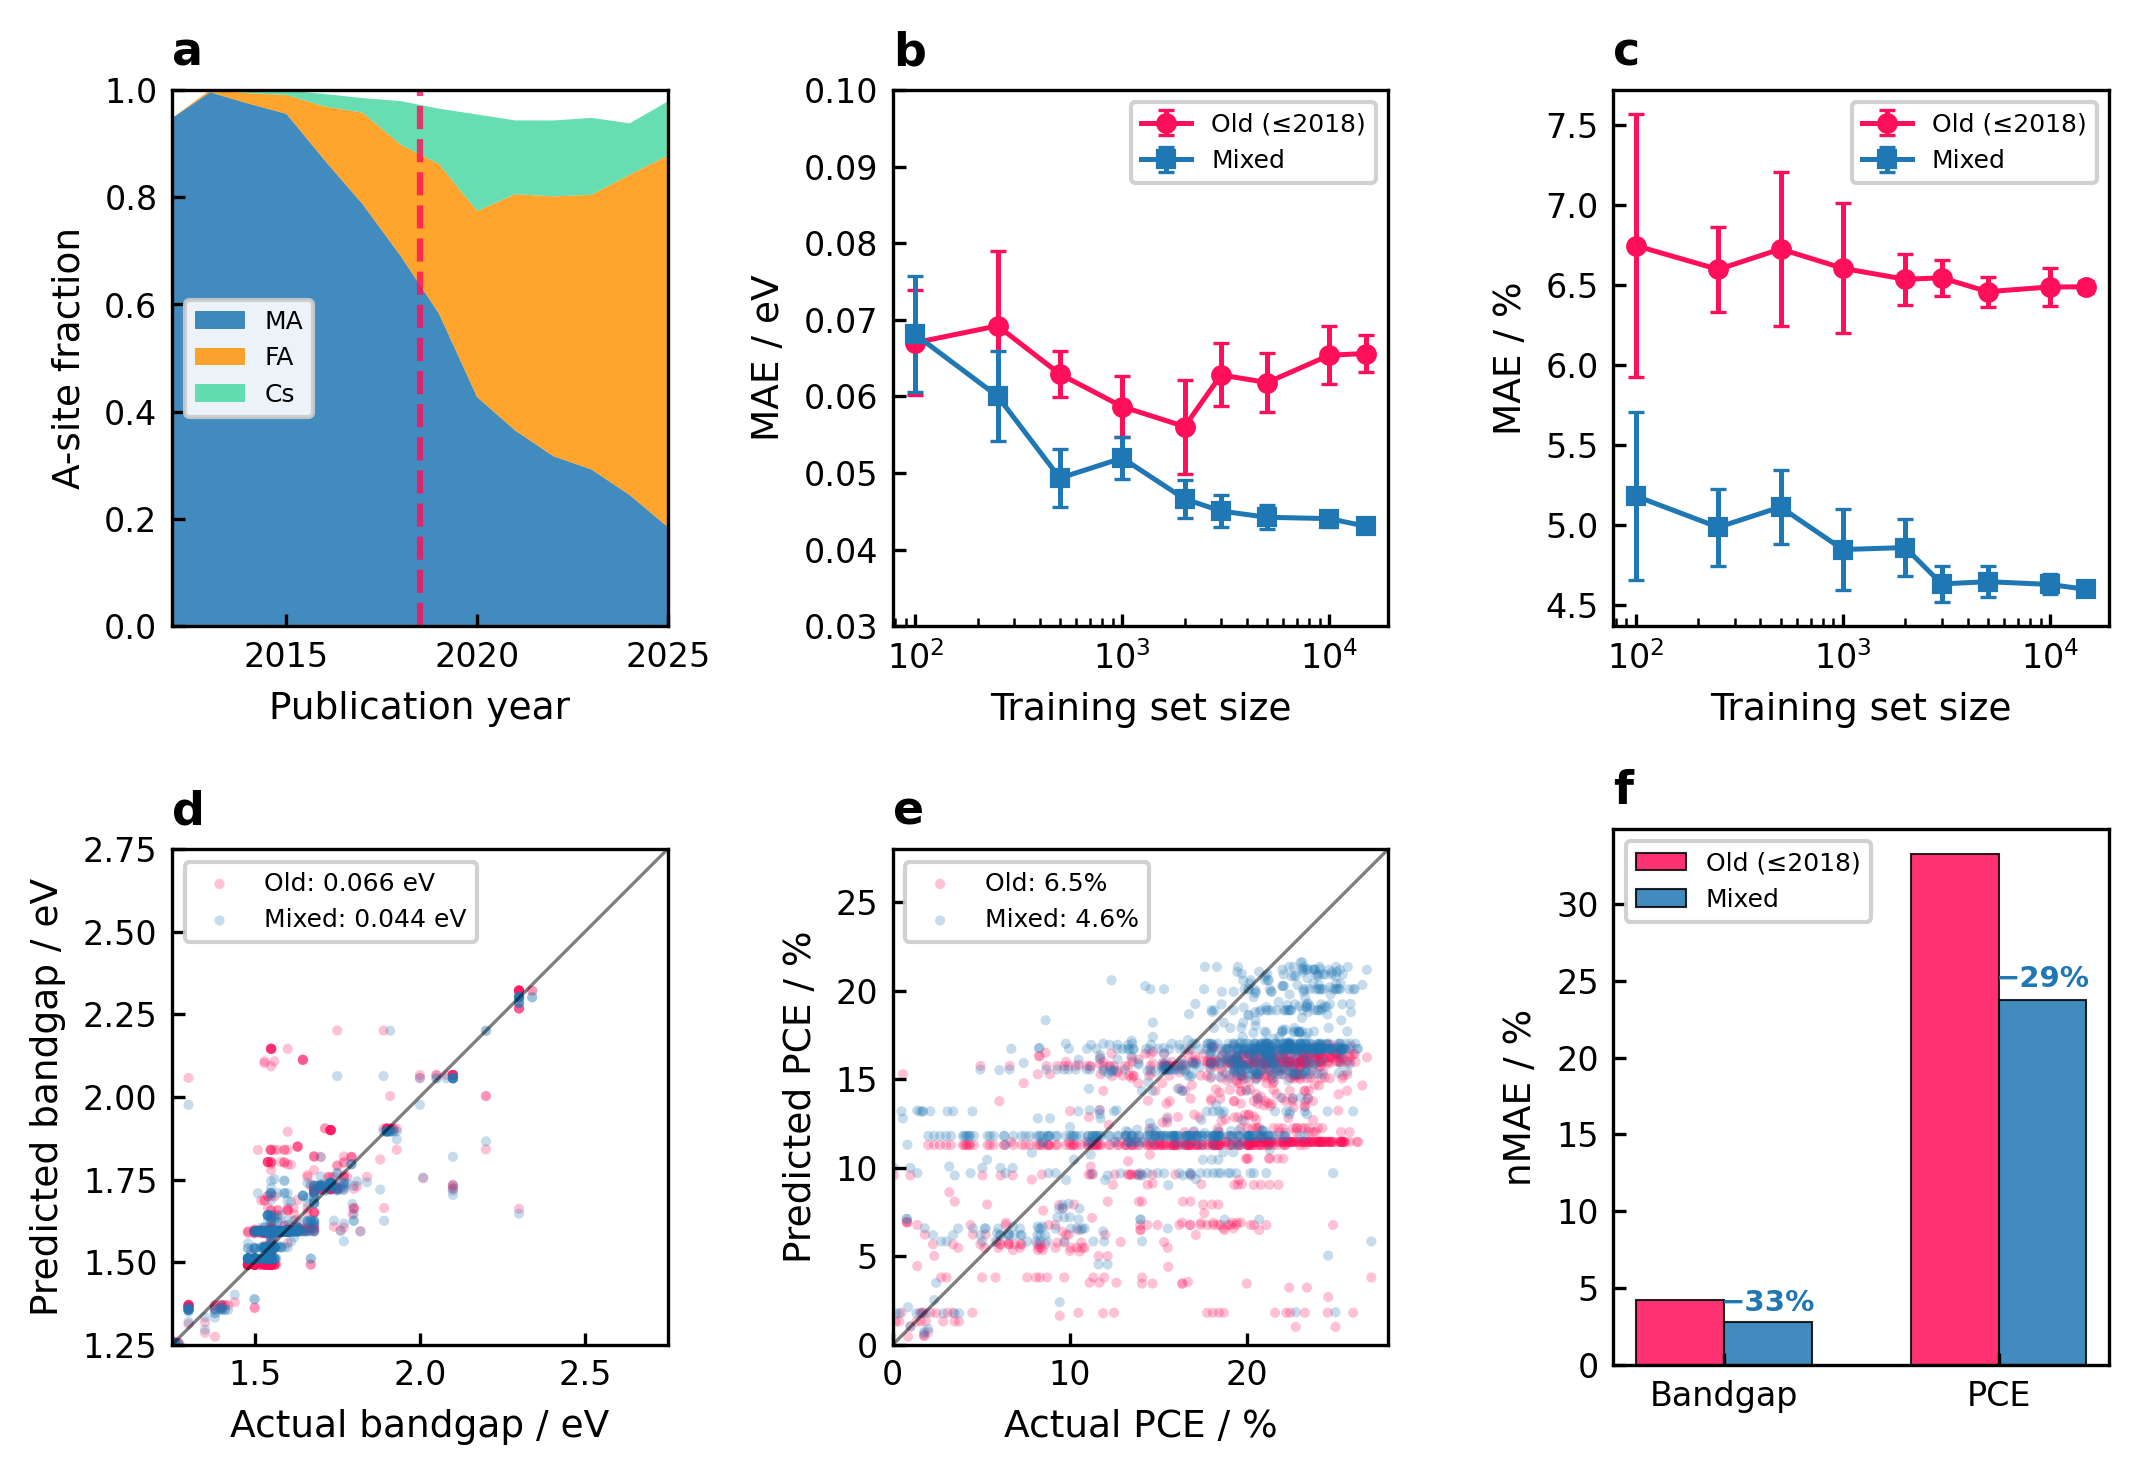


✓ Figure saved as fig_SI_ml_distribution_shift.pdf


In [8]:
fig = plt.figure(figsize=(7.2, 5.0))

c_old = colors['red']
c_mix = colors['blue']

# a: Composition shift
ax1 = fig.add_subplot(2, 3, 1)
yearly = df_valid.groupby('pub_year')[['A_MA', 'A_FA', 'A_Cs']].mean()
ax1.stackplot(
    yearly.index,
    yearly['A_MA'],
    yearly['A_FA'],
    yearly['A_Cs'],
    labels=['MA', 'FA', 'Cs'],
    colors=[colors['blue'], colors['orange'], colors['green']],
    alpha=0.85,
)
ax1.axvline(2018.5, color=colors['red'], linestyle='--', linewidth=1.5, alpha=0.8)
ax1.set_xlabel('Publication year')
ax1.set_ylabel('A-site fraction')
ax1.set_title('a', loc='left', fontweight='bold', fontsize=11)
ax1.legend(loc='center left', fontsize=6, framealpha=0.9)
ax1.set_xlim(2012, 2025)
ax1.set_ylim(0, 1)

# b: Learning curve - Bandgap
ax2 = fig.add_subplot(2, 3, 2)
ax2.errorbar(
    lc_bg['n'],
    lc_bg['mae_old'],
    yerr=lc_bg['mae_old_std'],
    fmt='o-',
    color=c_old,
    label='Old (≤2018)',
    capsize=2,
    capthick=0.8,
)
ax2.errorbar(
    lc_bg['n'],
    lc_bg['mae_mixed'],
    yerr=lc_bg['mae_mixed_std'],
    fmt='s-',
    color=c_mix,
    label='Mixed',
    capsize=2,
    capthick=0.8,
)
ax2.set_xlabel('Training set size')
ax2.set_ylabel('MAE / eV')
ax2.set_title('b', loc='left', fontweight='bold', fontsize=11)
ax2.legend(fontsize=6, framealpha=0.9)
ax2.set_xscale('log')
ax2.set_ylim(0.03, 0.10)

# c: Learning curve - PCE
ax3 = fig.add_subplot(2, 3, 3)
ax3.errorbar(
    lc_pce['n'],
    lc_pce['mae_old'],
    yerr=lc_pce['mae_old_std'],
    fmt='o-',
    color=c_old,
    label='Old (≤2018)',
    capsize=2,
    capthick=0.8,
)
ax3.errorbar(
    lc_pce['n'],
    lc_pce['mae_mixed'],
    yerr=lc_pce['mae_mixed_std'],
    fmt='s-',
    color=c_mix,
    label='Mixed',
    capsize=2,
    capthick=0.8,
)
ax3.set_xlabel('Training set size')
ax3.set_ylabel('MAE / %')
ax3.set_title('c', loc='left', fontweight='bold', fontsize=11)
ax3.legend(fontsize=6, framealpha=0.9)
ax3.set_xscale('log')

# d: Bandgap parity
ax4 = fig.add_subplot(2, 3, 4)
ax4.scatter(
    y_test_bg,
    pred_bg_old,
    alpha=0.25,
    s=6,
    c=c_old,
    label=f'Old: {mae_bg_old:.3f} eV',
    edgecolors='none',
)
ax4.scatter(
    y_test_bg,
    pred_bg_mix,
    alpha=0.25,
    s=6,
    c=c_mix,
    label=f'Mixed: {mae_bg_mix:.3f} eV',
    edgecolors='none',
)
ax4.plot([1.2, 2.8], [1.2, 2.8], 'k-', linewidth=0.8, alpha=0.5)
ax4.set_xlabel('Actual bandgap / eV')
ax4.set_ylabel('Predicted bandgap / eV')
ax4.set_title('d', loc='left', fontweight='bold', fontsize=11)
ax4.set_xlim(1.25, 2.75)
ax4.set_ylim(1.25, 2.75)
ax4.set_aspect('equal')
ax4.legend(fontsize=6, loc='upper left', framealpha=0.9)

# e: PCE parity
ax5 = fig.add_subplot(2, 3, 5)
ax5.scatter(
    y_test_pce,
    pred_pce_old,
    alpha=0.25,
    s=6,
    c=c_old,
    label=f'Old: {mae_pce_old:.1f}%',
    edgecolors='none',
)
ax5.scatter(
    y_test_pce,
    pred_pce_mix,
    alpha=0.25,
    s=6,
    c=c_mix,
    label=f'Mixed: {mae_pce_mix:.1f}%',
    edgecolors='none',
)
ax5.plot([0, 28], [0, 28], 'k-', linewidth=0.8, alpha=0.5)
ax5.set_xlabel('Actual PCE / %')
ax5.set_ylabel('Predicted PCE / %')
ax5.set_title('e', loc='left', fontweight='bold', fontsize=11)
ax5.set_xlim(0, 28)
ax5.set_ylim(0, 28)
ax5.set_aspect('equal')
ax5.legend(fontsize=6, loc='upper left', framealpha=0.9)

# f: nMAE comparison
ax6 = fig.add_subplot(2, 3, 6)
x = np.arange(2)
w = 0.32
bars1 = ax6.bar(
    x - w / 2,
    [nmae_bg_old, nmae_pce_old],
    w,
    label='Old (≤2018)',
    color=c_old,
    alpha=0.85,
    edgecolor='black',
    linewidth=0.5,
)
bars2 = ax6.bar(
    x + w / 2,
    [nmae_bg_mix, nmae_pce_mix],
    w,
    label='Mixed',
    color=c_mix,
    alpha=0.85,
    edgecolor='black',
    linewidth=0.5,
)
ax6.set_ylabel('nMAE / %')
ax6.set_title('f', loc='left', fontweight='bold', fontsize=11)
ax6.set_xticks(x)
ax6.set_xticklabels(['Bandgap', 'PCE'])
ax6.legend(fontsize=6, framealpha=0.9)

# Add improvement annotations
ax6.annotate(
    f'−{nmae_bg_impr:.0f}%',
    xy=(w / 2, nmae_bg_mix + 0.3),
    ha='center',
    va='bottom',
    fontsize=7,
    color=c_mix,
    fontweight='bold',
)
ax6.annotate(
    f'−{nmae_pce_impr:.0f}%',
    xy=(1 + w / 2, nmae_pce_mix + 0.5),
    ha='center',
    va='bottom',
    fontsize=7,
    color=c_mix,
    fontweight='bold',
)

plt.tight_layout()
plt.savefig('fig_SI_ml_distribution_shift.pdf', bbox_inches='tight', dpi=300)
plt.savefig('fig_SI_ml_distribution_shift.png', bbox_inches='tight', dpi=300)
plt.show()

print('\n✓ Figure saved as fig_SI_ml_distribution_shift.pdf')

## 8. Export Results

In [9]:
os.makedirs('SI_ml_case_study', exist_ok=True)

# Save learning curves
lc_bg.to_csv('SI_ml_case_study/learning_curve_bandgap.csv', index=False)
lc_pce.to_csv('SI_ml_case_study/learning_curve_pce.csv', index=False)

# Save model comparison
summary = pd.DataFrame(
    [
        {
            'Target': 'Bandgap',
            'Units': 'eV',
            'Training': 'Old',
            'MAE': mae_bg_old,
            'nMAE': nmae_bg_old,
        },
        {
            'Target': 'Bandgap',
            'Units': 'eV',
            'Training': 'Mixed',
            'MAE': mae_bg_mix,
            'nMAE': nmae_bg_mix,
        },
        {
            'Target': 'PCE',
            'Units': '%',
            'Training': 'Old',
            'MAE': mae_pce_old,
            'nMAE': nmae_pce_old,
        },
        {
            'Target': 'PCE',
            'Units': '%',
            'Training': 'Mixed',
            'MAE': mae_pce_mix,
            'nMAE': nmae_pce_mix,
        },
    ]
)
summary.to_csv('SI_ml_case_study/model_comparison_summary.csv', index=False)

print('✓ Results saved to SI_ml_case_study/')
print('\nFiles:')
for f in os.listdir('SI_ml_case_study'):
    print(f'  - {f}')

✓ Results saved to SI_ml_case_study/

Files:
  - model_comparison_summary.csv
  - learning_curve_bandgap.csv
  - learning_curve_pce.csv


## 9. Summary

In [11]:
print(f"""
{'=' * 65}
CASE STUDY SUMMARY: Distribution Shift in ML Property Prediction
{'=' * 65}

COMPOSITION SHIFT (2012–2018 → 2022–2025):
  MA: {old_data['A_MA'].mean():.0%} → {new_data['A_MA'].mean():.0%}
  FA: {old_data['A_FA'].mean():.0%} → {new_data['A_FA'].mean():.0%}
  Cs: {old_data['A_Cs'].mean():.0%} → {new_data['A_Cs'].mean():.0%}

MODEL PERFORMANCE (n=15,000 training samples - largest size, tested on 2022–2025 data):
  Bandgap: Old nMAE = {nmae_bg_old:.1f}%  →  Mixed nMAE = {nmae_bg_mix:.1f}%  ({nmae_bg_impr:.0f}% improvement)
  PCE:     Old nMAE = {nmae_pce_old:.1f}%  →  Mixed nMAE = {nmae_pce_mix:.1f}%  ({nmae_pce_impr:.0f}% improvement)
  Note: nMAE = MAE/median(actual) × 100 (normalized mean absolute error)
""")


CASE STUDY SUMMARY: Distribution Shift in ML Property Prediction

COMPOSITION SHIFT (2012–2018 → 2022–2025):
  MA: 80% → 27%
  FA: 14% → 56%
  Cs: 4% → 12%

MODEL PERFORMANCE (n=15,000 training samples - largest size, tested on 2022–2025 data):
  Bandgap: Old nMAE = 4.2%  →  Mixed nMAE = 2.8%  (33% improvement)
  PCE:     Old nMAE = 33.2%  →  Mixed nMAE = 23.7%  (29% improvement)
  Note: nMAE = MAE/median(actual) × 100 (normalized mean absolute error)

